# Introduction
Capstone Project : "Law as Data"

Team :  
Matt Dakolios (mrd7f)
Evan Dickson (ejd8zh)
Sud Luthra (sl3zs)

Reference : This notebook is based on code and direction provided by Prof. R. C. Alvarado

# Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy

# Configurations

In [2]:
sourceFilePath   = './src'
dataBasePath  = './db/'
dataBaseName = 'ussc_capstone.db'
# This variable controls if we save the initial data to tables.
# It needs to be set to yes atleast one time for the data to get stored on DB. From there on, set it to yes only if we want the data to be refreshed.
saveDataToTables = 'no'

class db(): pass

# Load the Data from CSV file

In [3]:
csvData = pd.read_csv(f'{sourceFilePath}/ussc_data.csv')

In [4]:
csvData.head(1)

,Index,Filename,Court,Full Date,Year,Opinion Author,Opinion,Concur 1 Author,Concur 1,Concur 2 Author,...,Concur 8 Author,Concur 8,Dissent 1 Author,Dissent 1,Dissent 2 Author,Dissent 2,Dissent 3 Author,Dissent 3,Dissent 4 Author,Dissent 4
0,1,266_US_342.txt,USSC,"December 8, 1924",1924,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove the spaces in the column names and set to same case for all.
csvData.columns = csvData.columns.str.lower().str.replace(' ', '_')

In [6]:
csvData.head(2)

,index,filename,court,full_date,year,opinion_author,opinion,concur_1_author,concur_1,concur_2_author,...,concur_8_author,concur_8,dissent_1_author,dissent_1,dissent_2_author,dissent_2,dissent_3_author,dissent_3,dissent_4_author,dissent_4
0,1,266_US_342.txt,USSC,"December 8, 1924",1924,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,233_US_16.txt,USSC,"April 6, 1914",1914,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
csvData[csvData['year']==1794]

,index,filename,court,full_date,year,opinion_author,opinion,concur_1_author,concur_1,concur_2_author,...,concur_8_author,concur_8,dissent_1_author,dissent_1,dissent_2_author,dissent_2,dissent_3_author,dissent_3,dissent_4_author,dissent_4
12521,12522,3_US_6.txt,USSC,"February 18, 1794",1794,JAY,BY THE COURT: The Judges being decidedly of op...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16430,16431,3_US_1.txt,USSC,"February 7, 1794",1794,JAY,"The argument having continued for four days, t...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
csvData.columns

Index(['index', 'filename', 'court', 'full_date', 'year', 'opinion_author',
       'opinion', 'concur_1_author', 'concur_1', 'concur_2_author', 'concur_2',
       'concur_3_author', 'concur_3', 'concur_4_author', 'concur_4',
       'concur_5_author', 'concur_5', 'concur_6_author', 'concur_6',
       'concur_7_author', 'concur_7', 'concur_8_author', 'concur_8',
       'dissent_1_author', 'dissent_1', 'dissent_2_author', 'dissent_2',
       'dissent_3_author', 'dissent_3', 'dissent_4_author', 'dissent_4'],
      dtype='object')

In [9]:
# get the case id from the filename
csvData['case_id'] = csvData.filename.apply(lambda x: x.split('.')[0])

In [10]:
csvData.filename.apply(lambda x: x.split('.')[0])

0        266_US_342
1         233_US_16
2        318_US_350
3          70_US_37
4        460_US_428
            ...    
22110     70_US_214
22111    251_US_373
22112     35_US_326
22113     32_US_625
22114    225_US_302
Name: filename, Length: 22115, dtype: object

In [11]:
csvData.head(2)

,index,filename,court,full_date,year,opinion_author,opinion,concur_1_author,concur_1,concur_2_author,...,concur_8,dissent_1_author,dissent_1,dissent_2_author,dissent_2,dissent_3_author,dissent_3,dissent_4_author,dissent_4,case_id
0,1,266_US_342.txt,USSC,"December 8, 1924",1924,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266_US_342
1,2,233_US_16.txt,USSC,"April 6, 1914",1914,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233_US_16


In [12]:
# get total number of records in the case 
csvData.count()[0]

22115

In [13]:
# get the group of column names and put them in a list

concur_cols       = [x for x in csvData.columns[csvData.columns.str.match('^concur_\d$')]]
concur_auth_cols  = [x for x in csvData.columns[csvData.columns.str.match('^concur_\d_.+$')]]
dissent_cols      = [x for x in csvData.columns[csvData.columns.str.match('^dissent_\d$')]]
dissent_auth_cols = [x for x in csvData.columns[csvData.columns.str.match('^dissent_\d_.+$')]]
case_cols         = set(csvData.columns) - set(concur_cols) - set(dissent_cols) - set(concur_auth_cols) - set(dissent_auth_cols) - {'opinion', 'opinion_author'}

In [14]:
print(concur_cols)
print(concur_auth_cols)
print(dissent_cols)
print(dissent_auth_cols)
print(case_cols)

['concur_1', 'concur_2', 'concur_3', 'concur_4', 'concur_5', 'concur_6', 'concur_7', 'concur_8']
['concur_1_author', 'concur_2_author', 'concur_3_author', 'concur_4_author', 'concur_5_author', 'concur_6_author', 'concur_7_author', 'concur_8_author']
['dissent_1', 'dissent_2', 'dissent_3', 'dissent_4']
['dissent_1_author', 'dissent_2_author', 'dissent_3_author', 'dissent_4_author']
{'index', 'filename', 'court', 'case_id', 'full_date', 'year'}


## CASE

In [15]:
db.CASE = csvData[case_cols]

In [16]:
db.CASE

,index,filename,court,case_id,full_date,year
0,1,266_US_342.txt,USSC,266_US_342,"December 8, 1924",1924
1,2,233_US_16.txt,USSC,233_US_16,"April 6, 1914",1914
2,3,318_US_350.txt,USSC,318_US_350,"March 1, 1943",1943
3,4,70_US_37.txt,USSC,70_US_37,"January 15, 1866",1866
4,5,460_US_428.txt,USSC,460_US_428,"March 22, 1983",1983
...,...,...,...,...,...,...
22110,22111,70_US_214.txt,USSC,70_US_214,"January 26, 1866",1866
22111,22112,251_US_373.txt,USSC,251_US_373,"January 19, 1920",1920
22112,22113,35_US_326.txt,USSC,35_US_326,"February 10, 1836",1836
22113,22114,32_US_625.txt,USSC,32_US_625,"March 6, 1833",1833


In [17]:
# db.CASE.case_id.str.split('_').to_frame().case_id.apply(pd.Series)[[0,2]]

In [18]:
# get the case num and volume num by first splitting the case_id, then convert it to frame and get 2 columsn and then finally rename them.
db.CASE = db.CASE.join(db.CASE.case_id.str.split('_').to_frame()\
            .case_id.apply(pd.Series)[[0, 2]]\
            .rename(columns={0:'vol_num',2:'case_num'}))

In [19]:
# change the case num and volume num to int
db.CASE['vol_num'] = db.CASE.vol_num.astype('int')
db.CASE['case_num'] = db.CASE.case_num.astype('int')

In [20]:
db.CASE = db.CASE.set_index(['vol_num','case_num']).sort_index()
db.CASE = db.CASE.drop(['index','court','filename','case_id'], axis=1)

In [21]:
db.CASE

full_date  year
vol_num case_num                         
3       1          February 7, 1794  1794
        6         February 18, 1794  1794
        17        February 20, 1795  1795
        121             AUGUST 1795  1795
        171           March 8, 1796  1796
...                             ...   ...
554     407           June 25, 2008  2008
        471           June 26, 2008  2008
        527           June 26, 2008  2008
        570           June 26, 2008  2008
        724           June 26, 2008  2008

[22115 rows x 2 columns]

### CORPUS

In [23]:
content_cols = ['opinion'] + concur_cols + dissent_cols
author_cols = ['opinion_author'] + concur_auth_cols + dissent_auth_cols
print(tuple(zip(author_cols, content_cols)))

(('opinion_author', 'opinion'), ('concur_1_author', 'concur_1'), ('concur_2_author', 'concur_2'), ('concur_3_author', 'concur_3'), ('concur_4_author', 'concur_4'), ('concur_5_author', 'concur_5'), ('concur_6_author', 'concur_6'), ('concur_7_author', 'concur_7'), ('concur_8_author', 'concur_8'), ('dissent_1_author', 'dissent_1'), ('dissent_2_author', 'dissent_2'), ('dissent_3_author', 'dissent_3'), ('dissent_4_author', 'dissent_4'))


In [24]:
dfs = []
for x, y in zip(author_cols, content_cols):
    df = csvData[['year','case_id', x, y]].copy()
    df = df.rename(columns={x:'author_id', y:'opinion'})
    df['position'] = x.split('_')[0]
    df = df.dropna()
    dfs.append(df)
db.CORPUS = pd.concat(dfs)
del(dfs)

In [25]:
db.CORPUS.head()

,year,case_id,author_id,opinion,position
0,1924,266_US_342,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,opinion
1,1914,233_US_16,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,opinion
2,1943,318_US_350,FRANKFURTER,MR. JUSTICE FRANKFURTER delivered the opinion ...,opinion
3,1866,70_US_37,FIELD,Mr. Justice FIELD delivered the opinion of the...,opinion
4,1983,460_US_428,BLACKMUN,JUSTICE BLACKMUN delivered the opinion of the ...,opinion


In [26]:
db.CORPUS['doc_len'] = db.CORPUS.opinion.str.len()
db.CORPUS[['vol_num','case_num']] = db.CORPUS.apply(lambda x: pd.Series(x.case_id.split('_')), 1)[[0,2]]
db.CORPUS.vol_num = db.CORPUS.vol_num.astype('int')
db.CORPUS.case_num = db.CORPUS.case_num.astype('int')
db.CORPUS.head()

,year,case_id,author_id,opinion,position,doc_len,vol_num,case_num
0,1924,266_US_342,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,opinion,14556,266,342
1,1914,233_US_16,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,opinion,9783,233,16
2,1943,318_US_350,FRANKFURTER,MR. JUSTICE FRANKFURTER delivered the opinion ...,opinion,10861,318,350
3,1866,70_US_37,FIELD,Mr. Justice FIELD delivered the opinion of the...,opinion,8867,70,37
4,1983,460_US_428,BLACKMUN,JUSTICE BLACKMUN delivered the opinion of the ...,opinion,34278,460,428


In [28]:
db.CORPUS = db.CORPUS.reset_index().set_index(['vol_num','case_num','author_id']).sort_index()
db.CORPUS = db.CORPUS[['year','position','opinion','doc_len']]
db.CORPUS

year position  \
vol_num case_num author_id                     
3       1        JAY           1794  opinion   
        6        JAY           1794  opinion   
        17       WILSON        1795  opinion   
        121      RUTLEDGE_J    1795  opinion   
        171      CHASE_SALMON  1796  opinion   
...                             ...      ...   
554     570      SCALIA        2008  opinion   
                 STEVENS       2008  dissent   
        724      ALITO         2008  opinion   
                 GINSBURG      2008   concur   
                 STEVENS       2008   concur   

                                                                         opinion  \
vol_num case_num author_id                                                         
3       1        JAY           The argument having continued for four days, t...   
        6        JAY           BY THE COURT: The Judges being decidedly of op...   
        17       WILSON        WILSON, Justice. The recognizance must be take...   
        121      RUTLEDGE_J    By the COURT: -- We have consulted together on...   
        171      CHASE_SALMON  THE COURT delivered their opinions seriatim in...   
...                                                                          ...   
554     570      SCALIA        Justice Scalia delivered the opinion of the Co...   
                 STEVENS       DISSENT BY: STEVENS; BREYER \nDISSENT \nJustic...   
        724      ALITO         Justice Alito delivered the opinion of the Cou...   
                 GINSBURG      Justice Ginsburg, with whom Justice Breyer joi...   
                 STEVENS       CONCUR BY: Stevens (In Part); Ginsburg (In Par...   

                               doc_len  
vol_num case_num author_id              
3       1        JAY              5712  
        6        JAY              2028  
        17       WILSON           2035  
        121      RUTLEDGE_J       8452  
        171      CHASE_SALMON     7826  
...                                ...  
554     570      SCALIA         107923  
                 STEVENS         62664  
        724      ALITO           40590  
                 GINSBURG         1253  
                 STEVENS         16154  

[34228 rows x 4 columns]

### AUTHOR

In [29]:
db.AUTHOR = db.CORPUS.reset_index()[['author_id','position']].value_counts().to_frame('n').unstack(fill_value=0)
db.AUTHOR.columns = db.AUTHOR.columns.droplevel(0)
db.AUTHOR.columns.name = ''

In [30]:
db.AUTHOR['n_authors'] = db.AUTHOR.apply(lambda x: len(x.name.split()), 1)
db.AUTHOR['n_opinions'] = db.AUTHOR[['opinion','concur','dissent']].sum(1)

In [31]:
db.AUTHOR

,concur,dissent,opinion,n_authors,n_opinions
author_id,,,,,
ALITO,10,13,17,1,40
BALDWIN,4,35,39,1,78
BARBOUR,0,3,17,1,20
BLACK,186,330,498,1,1014
BLACK CHIEF_JUSTICE DOUGLAS,1,0,0,3,1
...,...,...,...,...,...
WHITTAKER,16,34,42,1,92
WILSON,1,1,2,1,4
WOODBURY,1,13,40,1,54


In [32]:
csvData[csvData['opinion_author']=='ALITO']

,index,filename,court,full_date,year,opinion_author,opinion,concur_1_author,concur_1,concur_2_author,...,concur_8,dissent_1_author,dissent_1,dissent_2_author,dissent_2,dissent_3_author,dissent_3,dissent_4_author,dissent_4,case_id
482,483,551_US_587.txt,USSC,"June 25, 2007",2007,ALITO,Justice Alito announced the judgment of the Co...,KENNEDY,CONCUR BY: Kennedy; Scalia \nCONCUR \nJustice ...,SCALIA,...,NaN,SOUTER,"DISSENT BY: SOUTER \nDISSENT \nJustice Souter,...",NaN,NaN,NaN,NaN,NaN,NaN,551_US_587
2768,2769,547_US_319.txt,USSC,"May 1, 2006",2006,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,547_US_319
3495,3496,553_US_16.txt,USSC,"April 15, 2008",2008,ALITO,Justice Alito delivered the opinion of the Cou...,THOMAS,"CONCUR BY: Thomas \nCONCUR \nJustice Thomas, c...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,553_US_16
3607,3608,548_US_81.txt,USSC,"June 22, 2006",2006,ALITO,Justice Alito delivered the opinion of the Cou...,BREYER,"CONCUR BY: BREYER \nCONCUR \nJustice Breyer, c...",NaN,...,NaN,STEVENS,DISSENT BY: STEVENS \nDISSENT \nJustice Steven...,NaN,NaN,NaN,NaN,NaN,NaN,548_US_81
6442,6443,549_US_406.txt,USSC,"February 28, 2007",2007,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549_US_406
6777,6778,551_US_644.txt,USSC,"June 25, 2007",2007,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,STEVENS,DISSENT BY: STEVENS; BREYER \nDISSENT \nJustic...,BREYER,"Justice Breyer, dissenting. \nI join Justice S...",NaN,NaN,NaN,NaN,551_US_644
8001,8002,549_US_84.txt,USSC,"December 11, 2006",2006,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549_US_84
9460,9461,552_US_472.txt,USSC,"March 19, 2008",2008,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,THOMAS,"DISSENT BY: THOMAS \nDISSENT \nJustice Thomas,...",NaN,NaN,NaN,NaN,NaN,NaN,552_US_472
10739,10740,554_US_724.txt,USSC,"June 26, 2008",2008,ALITO,Justice Alito delivered the opinion of the Cou...,STEVENS,CONCUR BY: Stevens (In Part); Ginsburg (In Par...,GINSBURG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,554_US_724
11896,11897,553_US_377.txt,USSC,"May 19, 2008",2008,ALITO,Justice Alito delivered the opinion of the Cou...,NaN,NaN,NaN,...,NaN,SOUTER,"DISSENT BY: SOUTER \nDISSENT \nJustice Souter,...",NaN,NaN,NaN,NaN,NaN,NaN,553_US_377


In [33]:
db.AUTHOR.sort_values(by=['n_authors'])

,concur,dissent,opinion,n_authors,n_opinions
author_id,,,,,
ALITO,10,13,17,1,40
HUGHES,6,19,393,1,418
HUNT,4,7,144,1,155
IREDELL,2,1,0,1,3
JACKSON_H,3,4,21,1,28
...,...,...,...,...,...
CHIEF_JUSTICE MCKENNA VANDEVANTER MCREYNOLDS,0,1,0,4,1
FULLER BREWER WHITE_E MCKENNA,0,1,0,4,1
BREWER SHIRAS WHITE_E PECKHAM,0,1,0,4,1


<AxesSubplot:>

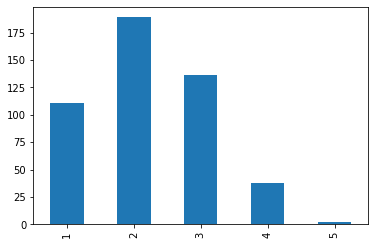

In [34]:
db.AUTHOR.n_authors.value_counts().sort_index().plot.bar()

In [35]:
# AUTHOR Success


In [36]:
db.AUTHOR['success'] = np.log((((db.AUTHOR.concur + db.AUTHOR.opinion + 1) / (db.AUTHOR.dissent + 1)) * (db.AUTHOR.n_opinions + 2)))

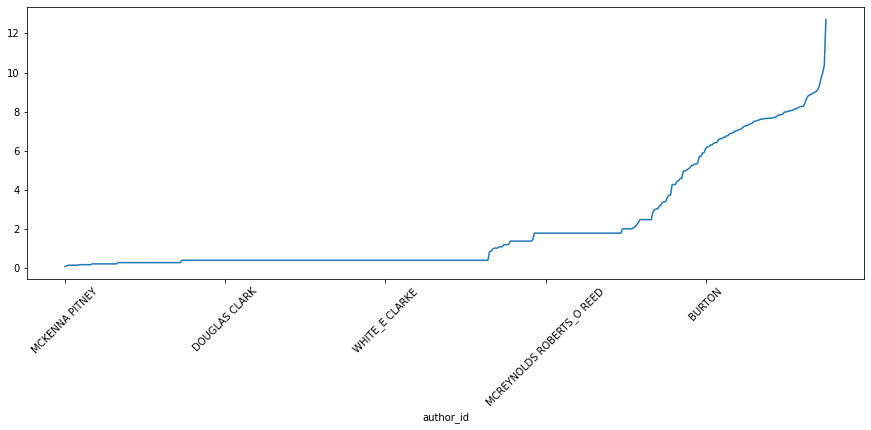

In [37]:
db.AUTHOR.success.sort_values().plot(figsize=(15,5), rot=45);

In [38]:
# Add stats to CASE

In [39]:
db.CASE['opinion_count'] = db.CORPUS.reset_index().groupby(['vol_num','case_num'])['position'].count().sort_values(ascending=False).to_frame()
db.CASE[['concur','dissent','opinion']] = db.CORPUS.groupby(['vol_num','case_num','position']).position.count().to_frame().unstack(fill_value=0)
db.CASE['doc_len_sum'] = db.CORPUS.groupby(['vol_num','case_num']).doc_len.sum()

# Review Cases

In [40]:
db.CASE.describe().T

,count,mean,std,min,25%,50%,75%,max
year,22115.0,1923.464707,46.272354,1789.0,1896.0,1923.0,1961.0,2008.0
opinion_count,22115.0,1.548903,0.911670,1.0,1.0,1.0,2.0,9.0
concur,22115.0,0.205517,0.550059,0.0,0.0,0.0,0.0,6.0
dissent,22115.0,0.342211,0.612645,0.0,0.0,0.0,1.0,4.0
opinion,22115.0,1.001176,0.034269,1.0,1.0,1.0,1.0,2.0
doc_len_sum,22115.0,20002.719783,22836.842285,64.0,6793.0,13037.0,24939.5,631307.0


In [41]:
db.CASE.head()

full_date  year  opinion_count  concur  dissent  \
vol_num case_num                                                            
3       1          February 7, 1794  1794              1       0        0   
        6         February 18, 1794  1794              1       0        0   
        17        February 20, 1795  1795              1       0        0   
        121             AUGUST 1795  1795              1       0        0   
        171           March 8, 1796  1796              5       3        1   

                  opinion  doc_len_sum  
vol_num case_num                        
3       1               1         5712  
        6               1         2028  
        17              1         2035  
        121             1         8452  
        171             1        30900

In [42]:
db.CASE.sort_values('opinion_count', ascending=False).head()

,,full_date,year,opinion_count,concur,dissent,opinion,doc_len_sum
vol_num,case_num,,,,,,,
60,393,"March 5, 1857",1857,9,6,2,1,631307
530,914,"June 28, 2000",2000,8,3,4,1,189109
343,579,"June 2, 1952",1952,7,5,1,1,168301
399,1,"June 22, 1970",1970,7,3,3,1,43105
433,425,"June 28, 1977",1977,7,4,2,1,202805


In [43]:
db.CASE.sort_values('doc_len_sum', ascending=False).head()

,,full_date,year,opinion_count,concur,dissent,opinion,doc_len_sum
vol_num,case_num,,,,,,,
60,393,"March 5, 1857",1857,9,6,2,1,631307
67,17,"March 10, 1863",1863,3,0,2,1,494184
367,1,"June 5, 1961",1961,5,0,4,1,329506
182,244,"May 27, 1901",1901,6,3,2,1,320133
79,457,"May 1, 1871",1871,5,1,3,1,317507


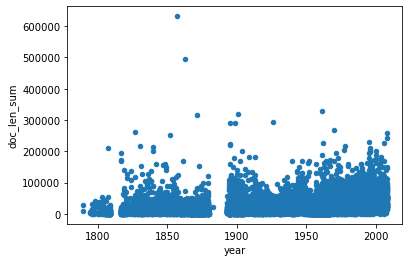

In [44]:
db.CASE.plot.scatter('year','doc_len_sum');

# Review Data By Year

In [45]:
db.YEAR = db.CORPUS.groupby(['year']).doc_len.sum().to_frame('doc_len_sum')
db.YEAR['doc_len_mean'] = db.CORPUS.groupby(['year']).doc_len.mean()
db.YEAR['opinion_count'] = db.CORPUS.groupby(['year']).opinion.count()

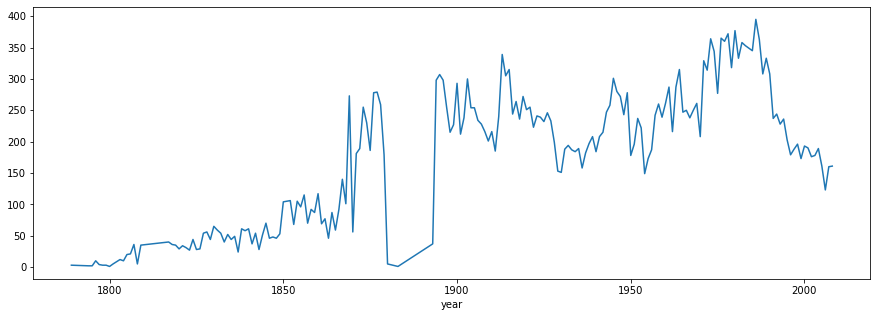

In [46]:
db.YEAR.opinion_count.plot(figsize=(15,5));

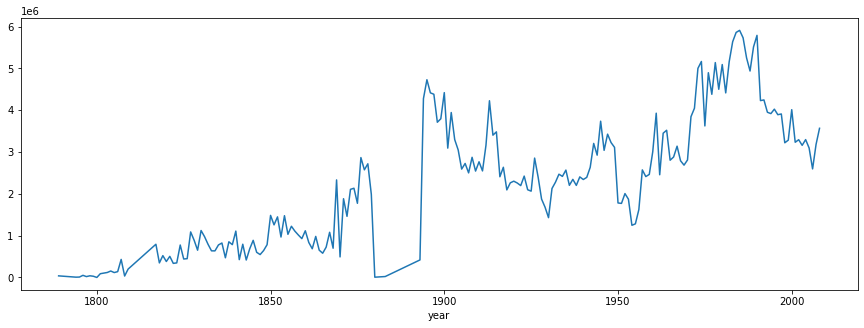

In [47]:
db.YEAR.doc_len_sum.plot(figsize=(15,5));

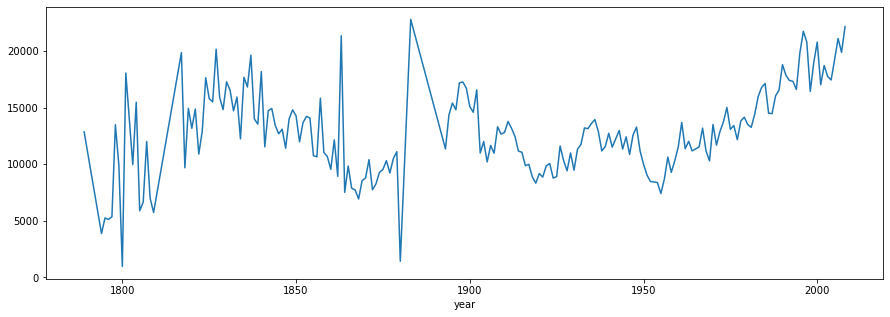

In [48]:
db.YEAR.doc_len_mean.plot(figsize=(15,5));

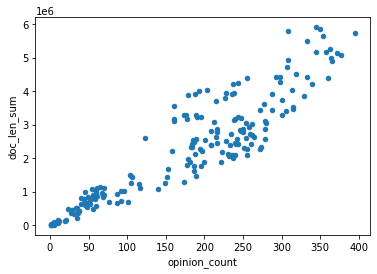

In [49]:
db.YEAR.reset_index().plot.scatter('opinion_count','doc_len_sum');

<AxesSubplot:xlabel='opinion_count', ylabel='doc_len_mean'>

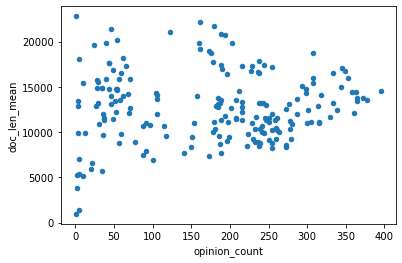

In [50]:
db.YEAR.plot.scatter('opinion_count','doc_len_mean')

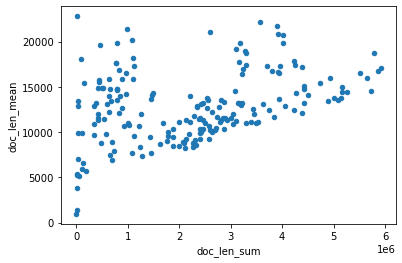

In [51]:
db.YEAR.reset_index().plot.scatter('doc_len_sum','doc_len_mean');

# Consolidate opinions 

In [52]:
M = db.CORPUS.groupby(['vol_num','case_num','position']).opinion.apply(lambda x: ' '.join(x)).to_frame().sort_index()

In [53]:
M.head(50)

opinion
vol_num case_num position                                                   
3       1        opinion   The argument having continued for four days, t...
        6        opinion   BY THE COURT: The Judges being decidedly of op...
        17       opinion   WILSON, Justice. The recognizance must be take...
        121      opinion   By the COURT: -- We have consulted together on...
        171      concur    IREDELL. Justice. -- I agree in opinion with m...
                 dissent   DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...
                 opinion   THE COURT delivered their opinions seriatim in...
        297      opinion   THE CHIEF JUSTICE informed the opposite counse...
        302      opinion   After advisement, THE CHIEF JUSTICE delivered ...
        308      opinion   The cause was held under advisement, till the ...
        321      dissent   DISSENT BY: WILSON\nWILSON, Justice. I conside...
                 opinion   ELSWORTH, Chief Justice. The question, how far...
        336      concur    CONCUR BY: CHASE\nCHASE, Justice: -- An accoun...
                 opinion   PATERSON, Justice: -- Though I was silent on t...
        344      opinion   On the 13th of February, 1797, WILSON Justice,...
        365      opinion   ELSWORTH, Chief Justice. In delivering the opi...
        386      concur    CONCUR BY: PATERSON\nPATERSON, Justice. The Co...
                 dissent   DISSENT BY: IREDELL\nIREDELL, Justice. Though ...
                 opinion   CHASE, Justice. The decision of one question d...
        425      concur    CONCUR BY: IREDELL\nIREDELL, Justice. 5 Though...
                 opinion   The CHIEF JUSTICE, on the last day of the term...
4       8        opinion   The Chief Justice delivered the opinion of the...
        34       opinion   On the 18th of August, PATERSON, Justice, stat...
5       1        opinion   August 11th.  Marshall, Chief Justice, deliver...
        45       opinion   The court took time till this term to consider...
        103      opinion   The Chief Justice delivered the opinion of the...
        110      opinion   The Court. It is true that the courts in Virgi...
        117      opinion   The Chief Justice delivered the opinion of the...
        137      opinion   Afterwards, on the 24th of February the follow...
        181      opinion   Feb. 17th.  The chief justice delivered the op...
        194      opinion   Feb. 26.  The Chief Justice delivered the opin...
        214      opinion   Feb. 23d.  The Chief Justice delivered the opi...
        239      opinion   March 1st. The chief justice delivered the opi...
        252      opinion   Feb. 23d.  The Chief Justice   delivered the o...
        290      opinion   Marshall, chief justice.\nIt is decided in Vir...
        299      opinion   Paterson, justice, (judge Cushing being absent...
        309      opinion   February 28th.  The Chief Justice delivered th...
        321      opinion   February 28th.  The Chief Justice, after stati...
        345      opinion   March 2d.  The Chief Justice, after stating th...
        365      opinion   Marshall, Chief justice. The law respecting th...
6       10       opinion   The case, as stated by Marshall, ch. j. in del...
        33       opinion   Feb. 22.  MARSHALL, Chief Justice, delivered t...
        64       opinion   Feb. 22d.  Marshall, Chief Justice, delivered ...
        127      concur    CONCUR BY: CHASE\nChase, Justice. -- I concur ...
                 opinion   February 25th. MARSHALL, CH. J. delivered the ...
        170      opinion   February 27.  MARSHALL, Chief Justice, now del...
        180      opinion   MARSHALL, Ch. J.  There can be no doubt of thi...
        187      opinion   March 5th. -- MARSHALL, C.J. delivered the opi...
        240      opinion   March 6th.  Marshall, Chief Justice, delivered...
        272      opinion   March 6th.  Cushing, Justice, delivered   the ...

In [54]:
M1 = M.unstack()

In [55]:
M1.head(5)

opinion  \
position                                                     concur   
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       IREDELL. Justice. -- I agree in opinion with m...   

                                                                     \
position                                                    dissent   
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...   

                                                                     
position                                                    opinion  
vol_num case_num                                                     
3       1         The argument having continued for four days, t...  
        6         BY THE COURT: The Judges being decidedly of op...  
        17        WILSON, Justice. The recognizance must be take...  
        121       By the COURT: -- We have consulted together on...  
        171       THE COURT delivered their opinions seriatim in...

In [56]:
M1.columns = M1.columns.droplevel(0)

In [57]:
M1.head()

position                                                     concur  \
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       IREDELL. Justice. -- I agree in opinion with m...   

position                                                    dissent  \
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...   

position                                                    opinion  
vol_num case_num                                                     
3       1         The argument having continued for four days, t...  
        6         BY THE COURT: The Judges being decidedly of op...  
        17        WILSON, Justice. The recognizance must be take...  
        121       By the COURT: -- We have consulted together on...  
        171       THE COURT delivered their opinions seriatim in...

In [58]:
db.CORPUS_COMPRESSED = M1[(~M1.dissent.isna()) & (~M1.opinion.isna())][['opinion','dissent']].stack().to_frame('doc_content')

In [59]:
db.CORPUS_COMPRESSED

doc_content
vol_num case_num position                                                   
3       171      opinion   THE COURT delivered their opinions seriatim in...
                 dissent   DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...
        321      opinion   ELSWORTH, Chief Justice. The question, how far...
                 dissent   DISSENT BY: WILSON\nWILSON, Justice. I conside...
        386      opinion   CHASE, Justice. The decision of one question d...
...                                                                      ...
554     471      dissent   DISSENT BY: Stevens (In Part); Ginsburg (In Pa...
        527      opinion   Justice Scalia delivered the opinion of the Co...
                 dissent   DISSENT BY: Stevens \nDISSENT \nJustice Steven...
        570      opinion   Justice Scalia delivered the opinion of the Co...
                 dissent   Justice Breyer, with whom Justice Stevens, Jus...

[12348 rows x 1 columns]

In [60]:
db.CORPUS_COMPRESSED['doc_len'] = db.CORPUS_COMPRESSED.doc_content.str.len()

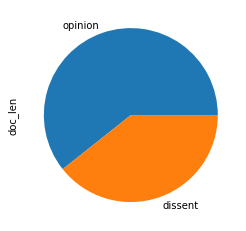

In [61]:
db.CORPUS_COMPRESSED.groupby('position').doc_len.mean().plot.pie();

# Save Data in DB Tables

In [62]:
 for table in db.__dict__.keys():
        print(table)

__module__
__dict__
__weakref__
__doc__
CASE
CORPUS
AUTHOR
YEAR
CORPUS_COMPRESSED


In [63]:
# confirm we are writing to the correct db
print(dataBaseName)

ussc_capstone.db


In [64]:
# one can override the variable here.
saveDataToTables = 'no'

if saveDataToTables=='yes':
    with sqlite3.connect(f'{dataBasePath}/{dataBaseName}') as conn:
        for table in db.__dict__.keys():
            if '__' not in table:
                print(table)
                df = getattr(db, table) 
                df.to_sql(table, conn, if_exists='replace', index=True)

In [65]:
# conn = sqlite3.connect('./db/ussc_capstone.db')
with sqlite3.connect(f'{dataBasePath}/{dataBaseName}') as conn:
    cur = conn.cursor()
    #get all the table names
    cur.execute(''' SELECT name FROM sqlite_master WHERE type='table' ''')
    rows = cur.fetchall()

    for row in rows:
        print(row)


('VOCAB',)
('BOW',)
('THETA',)
('CORPUS',)
('AUTHOR',)
('YEAR',)
('CORPUS_COMPRESSED',)
('CASE',)
('TOPICS',)
('THETA_NMF',)
('TOPICS_NMF',)


# Add Case Title (Related Notebook)

Add case title to the case table by running the code from the file Capstone_Related_1_CaseTitles.ipynb

# Generate Vector Spaces

In [66]:
# import pandas as pd
# import numpy as np
# import sqlite3
# import sqlalchemy
# 
n_terms     = 4000      # Vocabulary size
ngram_range = (1,2)     # ngram min and max lengths
n_topics    = 40        # Number of topics
max_iter    = 10        # Number of iterations for topic model


# Import CORPUS

In [67]:
dbconn = sqlalchemy.create_engine('sqlite:///db/ussc_capstone.db')
# class db(): pass

In [68]:
for table in db.__dict__.keys():
    print(table)

__module__
__dict__
__weakref__
__doc__
CASE
CORPUS
AUTHOR
YEAR
CORPUS_COMPRESSED


In [70]:
# test connectivity 
casetest = pd.read_sql('CASE', dbconn)
casetest.head(2)

,vol_num,case_num,year,full_date,opinion_count,concur,dissent,opinion,doc_len_sum,case_title
0,3,1,1794,"February 7, 1794",1,0,0,1,5712,"Georgia v. Brailsford, Powell & Hopton"
1,3,6,1794,"February 18, 1794",1,0,0,1,2028,Glass v. The Betsey


In [71]:
CORPUS = pd.read_sql('CORPUS_COMPRESSED', dbconn).set_index(['vol_num','case_num','position']).sort_index()

In [72]:
CORPUS

doc_content  \
vol_num case_num position                                                      
3       171      dissent   DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...   
                 opinion   THE COURT delivered their opinions seriatim in...   
        321      dissent   DISSENT BY: WILSON\nWILSON, Justice. I conside...   
                 opinion   ELSWORTH, Chief Justice. The question, how far...   
        386      dissent   DISSENT BY: IREDELL\nIREDELL, Justice. Though ...   
...                                                                      ...   
554     471      opinion   Justice Souter delivered the opinion of the Co...   
        527      dissent   DISSENT BY: Stevens \nDISSENT \nJustice Steven...   
                 opinion   Justice Scalia delivered the opinion of the Co...   
        570      dissent   Justice Breyer, with whom Justice Stevens, Jus...   
                 opinion   Justice Scalia delivered the opinion of the Co...   

                           doc_len  
vol_num case_num position           
3       171      dissent       252  
                 opinion      7826  
        321      dissent     16365  
                 opinion       824  
        386      dissent      8908  
...                            ...  
554     471      opinion     63276  
        527      dissent     25244  
                 opinion     45723  
        570      dissent    150367  
                 opinion    107923  

[12348 rows x 2 columns]

# Convert to Bag of Words 


Using Scikit Learn's CountVectorizer to convert our corpus of documents into a document-term vector space of word counts.

In [73]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [74]:
count_engine = CountVectorizer(max_features=n_terms, stop_words='english', ngram_range=ngram_range)
count_model = count_engine.fit_transform(CORPUS.doc_content)

## Get Generated VOCAB

In [75]:
db.VOCAB = pd.DataFrame(count_engine.get_feature_names(), columns=['term_str'])
db.VOCAB = db.VOCAB.set_index('term_str')
db.VOCAB['ngram_len'] = None # To be added later

In [76]:
db.VOCAB.sample(10)

,ngram_len
term_str,
shareholders,None
young,None
louis,None
privileges,None
serves,None
assault,None
pay,None
secretary,None
guard,None


## VOCAB Generated BOW

We do this just to show what the counter vectorizer produced. `DTM` stands for documet-term matrix. We convert this sparse matrix into a "thin" dataframe that keeps only terms with counts for each document. 

In [77]:
db.DTM = pd.DataFrame(count_model.toarray(), index=CORPUS.index, columns=db.VOCAB.index)
db.BOW = db.DTM.stack().to_frame('n')
db.BOW = db.BOW[db.BOW.n > 0]

In [78]:
db.DTM.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12348 entries, (3, 171, 'dissent') to (554, 570, 'opinion')
Columns: 4000 entries, 000 to zone
dtypes: int64(4000)
memory usage: 377.0+ MB


In [79]:
db.BOW.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5701266 entries, (3, 171, 'dissent', 'affirmed') to (554, 570, 'opinion', 'young')
Columns: 1 entries, n to n
dtypes: int64(1)
memory usage: 81.8+ MB


## Compute TF-IDF

In [80]:
tfidf_engine = TfidfTransformer()
tfidf_model = tfidf_engine.fit_transform(count_model)

In [81]:
db.TFIDF = pd.DataFrame(tfidf_model.toarray(), index=CORPUS.index, columns=db.VOCAB.index)
db.TFIDF.head()

term_str                        000  000 000   10       100  101  102  103  \
vol_num case_num position                                                    
3       171      dissent   0.000000      0.0  0.0  0.000000  0.0  0.0  0.0   
                 opinion   0.015294      0.0  0.0  0.015748  0.0  0.0  0.0   
        321      dissent   0.000000      0.0  0.0  0.000000  0.0  0.0  0.0   
                 opinion   0.000000      0.0  0.0  0.000000  0.0  0.0  0.0   
        386      dissent   0.000000      0.0  0.0  0.000000  0.0  0.0  0.0   

term_str                   104  104 ct  105  ...  wrong  wrongful  wrote  \
vol_num case_num position                    ...                           
3       171      dissent   0.0     0.0  0.0  ...    0.0       0.0    0.0   
                 opinion   0.0     0.0  0.0  ...    0.0       0.0    0.0   
        321      dissent   0.0     0.0  0.0  ...    0.0       0.0    0.0   
                 opinion   0.0     0.0  0.0  ...    0.0       0.0    0.0   
        386      dissent   0.0     0.0  0.0  ...    0.0       0.0    0.0   

term_str                        xxx  year  years  years ago  york  young  zone  
vol_num case_num position                                                       
3       171      dissent   0.249446   0.0    0.0        0.0   0.0    0.0   0.0  
                 opinion   0.000000   0.0    0.0        0.0   0.0    0.0   0.0  
        321      dissent   0.009982   0.0    0.0        0.0   0.0    0.0   0.0  
                 opinion   0.000000   0.0    0.0        0.0   0.0    0.0   0.0  
        386      dissent   0.024362   0.0    0.0        0.0   0.0    0.0   0.0  

[5 rows x 4000 columns]

In [82]:
db.BOW['tfidf'] = db.TFIDF.stack()

In [83]:
for table in db.__dict__.keys():
    print(table)

__module__
__dict__
__weakref__
__doc__
CASE
CORPUS
AUTHOR
YEAR
CORPUS_COMPRESSED
VOCAB
DTM
BOW
TFIDF


In [84]:
db.BOW

n     tfidf
vol_num case_num position term_str                  
3       171      dissent  affirmed       1  0.188874
                          argument       1  0.187804
                          cause          1  0.200595
                          circuit        1  0.203941
                          circuit court  1  0.285703
...                                     ..       ...
554     570      opinion  wrote          8  0.020297
                          year           5  0.007938
                          years          8  0.010349
                          york           8  0.012858
                          young          4  0.011191

[5701266 rows x 2 columns]

## Add Features to VOCAB

In [85]:
db.VOCAB[['n_dissent','n_opinion']] = db.BOW.groupby(['term_str','position']).n.sum().unstack()

In [86]:
db.VOCAB[['tfidf_mean_dissent','tfidf_mean_opinion']] = db.BOW.groupby(['term_str','position']).tfidf.mean().unstack()

In [87]:
db.VOCAB['ngram_len'] = db.VOCAB.apply(lambda x: len(x.name.split()), 1)
db.VOCAB['n'] = db.DTM.sum()
db.VOCAB['tfidf_mean'] = db.TFIDF.mean()

In [88]:
db.VOCAB.sort_values('tfidf_mean_dissent', ascending=False).head(20)

,ngram_len,n_dissent,n_opinion,tfidf_mean_dissent,tfidf_mean_opinion,n,tfidf_mean
term_str,,,,,,,
dissented,1,653,373,0.340650,0.013286,1026,0.017625
erisa,1,372,677,0.282743,0.268979,1049,0.001359
copyright,1,750,971,0.251849,0.219522,1721,0.001778
arbitration,1,960,1638,0.204579,0.174008,2598,0.003800
____,1,730,270,0.181868,0.077553,1000,0.000988
abortion,1,876,1141,0.170398,0.202744,2017,0.001805
liquors,1,341,554,0.167500,0.103268,895,0.001559
obscenity,1,396,545,0.165025,0.154501,941,0.001770
picketing,1,595,906,0.164289,0.150234,1501,0.002291


In [89]:
db.VOCAB.sort_values('tfidf_mean_opinion', ascending=False).head(20)

,ngram_len,n_dissent,n_opinion,tfidf_mean_dissent,tfidf_mean_opinion,n,tfidf_mean
term_str,,,,,,,
erisa,1,372,677,0.282743,0.268979,1049,0.001359
copyright,1,750,971,0.251849,0.219522,1721,0.001778
abortion,1,876,1141,0.170398,0.202744,2017,0.001805
arbitration,1,960,1638,0.204579,0.174008,2598,0.003800
martial,1,537,564,0.139803,0.161275,1101,0.001461
obscene,1,401,758,0.138585,0.159094,1159,0.002170
deportation,1,651,1232,0.159931,0.156403,1883,0.002864
obscenity,1,396,545,0.165025,0.154501,941,0.001770
patent,1,2808,5250,0.153918,0.151840,8058,0.008308


In [90]:
db.VOCAB.ngram_len.value_counts()

1    3677
2     323
Name: ngram_len, dtype: int64

# Generate Topic Models

Use Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [91]:
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

## Using LDA

In [92]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

### THETA

The Document-Term Matrix

In [93]:
db.THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=CORPUS.index)
db.THETA.index.name = 'doc_id'
db.THETA.columns.name = 'topic_id'

In [94]:
db.THETA.head(20).style.background_gradient(axis=1)

# PHI

In [95]:
db.PHI = pd.DataFrame(lda_engine.components_, columns=db.VOCAB.index)
db.PHI.index.name = 'topic_id'
db.PHI.columns.name = 'term_str'

In [96]:
db.PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000,1553.637848,65.407266,0.125266,65.622506,299.562255,25.179877,17.913695,49.687370,2.239989,5.081494,628.439494,231.902750,35.772734,363.097204,1.810997,34.464415,259.031047,2.775564,0.975317,54.341982,106.184422,0.623962,94.680051,259.663165,0.025000,867.515780,234.559986,142.106671,14.033432,452.609683,2705.521014,28.333109,52.550797,25.188094,21.915977,28.236047,259.604552,382.110881,37.326066,50.142242
000 000,244.085700,3.008650,0.025000,0.463412,0.941354,0.025000,0.025000,2.729871,0.025000,0.025000,111.435080,41.575094,0.025000,0.235028,0.025000,0.025000,0.948520,0.025000,0.025000,14.657041,7.384540,0.025000,0.025000,4.825079,0.025000,28.285607,1.782753,6.574387,0.025000,0.025000,435.004741,0.025000,0.025000,0.025000,0.025000,0.025000,111.644485,69.499297,0.025000,34.394362
10,809.681943,287.692338,282.183839,796.137909,327.048595,353.827867,160.107967,173.928017,323.247266,48.436699,131.755270,205.784245,275.438894,619.565711,413.878833,199.592297,119.575252,282.264767,148.083542,267.929065,258.854648,25.783568,1161.344410,358.055893,195.890724,192.144707,345.451128,125.469375,103.181660,1407.969891,489.625593,277.499741,545.045371,559.070532,536.776934,355.033248,84.085486,385.555315,203.874624,102.126838
100,190.370792,48.483386,11.667030,119.095319,102.673164,83.777888,14.305062,9.593398,55.990384,27.432670,179.739952,175.427812,186.287126,121.292474,61.562217,76.758580,62.362451,12.582154,72.818744,50.047472,44.750450,20.222482,30.220986,58.168916,30.599489,52.241942,31.142055,5.741588,23.219864,124.502595,339.272234,201.713282,106.544424,935.747872,155.040253,29.503305,95.542277,141.777085,131.258538,10.522288
101,152.525743,75.190107,7.138726,81.510623,15.756212,8.830327,30.117414,6.585578,185.127591,71.703157,50.809802,19.255061,8.614717,69.359574,159.291463,5.536771,2.276193,0.943085,8.297371,35.401260,16.318419,2.591074,77.185621,7.008510,43.377645,7.175285,6.953485,2.851539,0.496442,127.897627,81.470933,283.036265,96.399326,773.796756,100.551572,10.362626,12.052664,1.038238,2.309755,2.855443


### Create Topic Glosses

In [97]:
n_top_words = 7

In [98]:
db.TOPICS = db.PHI.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [99]:
db.TOPICS

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
0,stock,bankruptcy,court,trust,securities,corporation,assets
1,united,united states,states,committee,government,petitioner,act
2,court,jury,evidence,trial,defendant,case,state
3,child,children,medical,benefits,state,court,women
4,political,state,election,party,voting,vote,county
5,search,court,fourth,warrant,fourth amendment,amendment,police
6,court,state,case,jurisdiction,judgment,law,states
7,religious,school,state,religion,schools,education,public
8,state,federal,court,law,courts,jurisdiction,states


In [100]:
db.TOPICS['topwords'] = db.TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

In [101]:
db.TOPICS

term_str,0,1,2,3,4,5,6,topwords
topic_id,,,,,,,,
0,stock,bankruptcy,court,trust,securities,corporation,assets,"0 stock, bankruptcy, court, trust, securities,..."
1,united,united states,states,committee,government,petitioner,act,"1 united, united states, states, committee, go..."
2,court,jury,evidence,trial,defendant,case,state,"2 court, jury, evidence, trial, defendant, cas..."
3,child,children,medical,benefits,state,court,women,"3 child, children, medical, benefits, state, c..."
4,political,state,election,party,voting,vote,county,"4 political, state, election, party, voting, v..."
5,search,court,fourth,warrant,fourth amendment,amendment,police,"5 search, court, fourth, warrant, fourth amend..."
6,court,state,case,jurisdiction,judgment,law,states,"6 court, state, case, jurisdiction, judgment, ..."
7,religious,school,state,religion,schools,education,public,"7 religious, school, state, religion, schools,..."
8,state,federal,court,law,courts,jurisdiction,states,"8 state, federal, court, law, courts, jurisdic..."


### Add Doc Weights

In [102]:
db.TOPICS['doc_weight_sum'] = db.THETA.sum()

In [103]:
db.TOPICS.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

term_str,topwords,doc_weight_sum
topic_id,,
21,"21 justice, mr, mr justice, dissent, court, dissenting, case",1357.806087
26,"26 court, district, petitioner, district court, appeals, court appeals, case",598.441705
6,"6 court, state, case, jurisdiction, judgment, law, states",596.750701
16,"16 case, law, evidence, bank, court, said, contract",445.050056
29,"29 congress, statute, act, united, united states, states, language",403.773173
8,"8 state, federal, court, law, courts, jurisdiction, states",387.298366
22,"22 court, act, district, order, district court, review, congress",385.728609
19,"19 states, power, congress, united, united states, constitution, act",384.183585
2,"2 court, jury, evidence, trial, defendant, case, state",381.105210


## Using NMF

In [104]:
nmf_engine = NMF(n_components=n_topics, init='nndsvd', random_state=1, alpha=.1, l1_ratio=.5)

### THETA

In [105]:
db.THETA_NMF = pd.DataFrame(nmf_engine.fit_transform(tfidf_model), index=CORPUS.index)
db.THETA_NMF.columns.name = 'topic_id'

In [106]:
db.THETA_NMF.sample(20).style.background_gradient()

,,topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
vol_num,case_num,position,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
287,97,dissent,0.022376,0.007834,0.008838,0.000000,0.000000,0.000000,0.000000,0.000849,0.000000,0.000000,0.000000,0.000000,0.006786,0.029184,0.000000,0.000000,0.010134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054052,0.000000,0.000000,0.000000,0.000897,0.004372,0.000000
476,340,dissent,0.003968,0.001353,0.055768,0.000000,0.000287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010905,0.001959,0.000000,0.000000,0.000000,0.000000,0.000000
392,183,dissent,0.000000,0.006723,0.012682,0.000000,0.009526,0.012066,0.043901,0.046640,0.077502,0.000000,0.000000,0.000000,0.013392,0.000000,0.000000,0.002171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008966,0.023716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
192,371,opinion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.040228,0.004932,0.000000,0.000000,0.000000,0.065131,0.000000,0.048141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000652,0.000000,0.004462,0.000000,0.006273,0.009847,0.000000,0.000000,0.004545,0.000000
553,723,dissent,0.019661,0.000000,0.009846,0.104548,0.000000,0.000000,0.017778,0.000000,0.000000,0.000000,0.000000,0.000000,0.013671,0.005032,0.000000,0.000000,0.000000,0.000997,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022558,0.000000,0.000000,0.000000,0.000718,0.000000,0.000000,0.119829,0.000000
233,354,opinion,0.003972,0.000000,0.000000,0.000000,0.000000,0.000000,0.002732,0.028941,0.000000,0.000000,0.000000,0.003468,0.000000,0.049907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061788,0.000000,0.000000,0.000289,0.005068,0.000000,0.000000,0.000000,0.002352,0.000000,0.000351,0.017075,0.000000,0.000000,0.000000,0.000000
312,349,opinion,0.001023,0.000563,0.031895,0.000000,0.000000,0.006881,0.001560,0.000341,0.092555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
324,9,dissent,0.016706,0.018726,0.000000,0.000000,0.000000,0.054179,0.000000,0.002541,0.000000,0.000000,0.000000,0.000000,0.001658,0.009345,0.000000,0.000000,0.000000,0.000000,0.001791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018735,0.000000,0.000000,0.000000,0.000000
372,391,opinion,0.022735,0.001216,0.011168,0.000000,0.000000,0.000000,0.002810,0.047749,0.000000,0.000000,0.000000,0.000000,0.000061,0.011038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001659,0.000000,0.000281,0.000000,0.001374,0.001545,0.000000,0.000000,0.202036,0.000000


### PHI

In [114]:
db.PHI_NMF = pd.DataFrame(nmf_engine.components_, columns=db.VOCAB.index)

In [115]:
db.PHI_NMF.index.name = 'topic_id'
db.PHI_NMF.columns.name = 'term_str'

In [116]:
db.PHI_NMF.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000,0.048479,0.000000,0.045279,0.000000,0.110083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201255,0.011799,0.029554,0.000000,0.009884,0.046192,0.000000,0.000000,0.092829,0.000000,0.055097,0.000000,0.000000,0.062493,0.071082,0.123208,0.013511,0.141070,0.137425,0.000000,0.000000,0.000000,0.012429,0.000000,0.000000,0.029415,0.000000,0.000000,0.024295
000 000,0.000000,0.000000,0.000000,0.000000,0.015067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035246,0.000000,0.000000,0.000000,0.000000,0.000000,0.002292,0.020100,0.000000,0.017194,0.043127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.091573,0.000000,0.207873,0.059230,0.016079,0.044790,0.000000,0.000000,0.000000,0.000000,0.025708,0.006995,0.065901,0.025595,0.000000,0.008356,0.033219,0.000000,0.020670,0.022646,0.000000,0.012651,0.000000,0.000000,0.007449,0.000000,0.001488,0.009078,0.021743,0.022885,0.006713,0.004358,0.000000,0.000000,0.027159,0.000000,0.000000,0.004378,0.001800,0.000000
100,0.017035,0.000000,0.031800,0.089907,0.023301,0.007989,0.000692,0.009946,0.009682,0.000000,0.009933,0.025305,0.031345,0.009809,0.000000,0.000000,0.000000,0.001855,0.006251,0.011622,0.000000,0.009553,0.000000,0.000000,0.007294,0.000000,0.000000,0.010525,0.014355,0.022184,0.011802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,0.015587,0.000000,0.046000,0.086512,0.001601,0.019103,0.000000,0.013905,0.000000,0.000000,0.000000,0.000000,0.015076,0.000000,0.039617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000835,0.000000,0.000000,0.000000,0.000000,0.000000,0.018122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Topics

In [117]:
db.TOPICS_NMF = db.PHI_NMF.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str).rename_axis(columns={'term_str':'topic_features'})

In [118]:
db.TOPICS_NMF

topic_features,0,1,2,3,4,5,6
topic_id,,,,,,,
0,court,district,district court,appeals,court appeals,case,courts
1,xxx,mr justice,mr,justice,dissent,chief justice,chief
2,congress,act,statute,secretary,federal,legislative,section
3,ed 2d,ct,ed,2d,ante,id,3d
4,tax,income,taxes,taxation,taxpayer,revenue,taxable
5,union,board,labor,employees,employer,bargaining,collective
6,states,united states,united,government,power,constitution,war
7,state,federal,court,law,jurisdiction,state court,constitution
8,commerce,interstate,interstate commerce,transportation,commerce clause,state,intrastate


In [119]:
db.TOPICS_NMF['topwords'] = db.TOPICS_NMF.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

### Add Doc Weights - NMF


In [120]:
db.TOPICS_NMF['doc_weight_sum'] = db.THETA_NMF.sum()

In [121]:
db.TOPICS_NMF.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

topic_features,topwords,doc_weight_sum
topic_id,,
0,"0 court, district, district court, appeals, court appeals, case, courts",142.860795
13,"13 plaintiff, case, court, law, defendant, judgment, said",133.340078
2,"2 congress, act, statute, secretary, federal, legislative, section",130.659881
12,"12 speech, amendment, public, ordinance, court, city, constitutional",127.394896
7,"7 state, federal, court, law, jurisdiction, state court, constitution",100.019478
6,"6 states, united states, united, government, power, constitution, war",90.213519
34,"34 counsel, trial, defendant, witness, accused, testimony, evidence",81.928820
3,"3 ed 2d, ct, ed, 2d, ante, id, 3d",81.513568
1,"1 xxx, mr justice, mr, justice, dissent, chief justice, chief",78.295554


# Save the Vector Spaces in DB

In [175]:
# saveDataToTables = 'yes'

# if saveDataToTables=='yes':
#     with sqlite3.connect(f'{dataBasePath}/{dataBaseName}') as conn:
#         for table in db.__dict__.keys():
#             if '__' not in table:
#                 print(table)
#                 df = getattr(db, table) 
#                 df.to_sql(table, conn, if_exists='replace', index=True)

In [125]:
import sqlalchemy
from sqlite3 import OperationalError

dbconn = sqlalchemy.create_engine('sqlite:///db/ussc_capstone.db')

# one can override the variable here.
saveDataToTables = 'no'

if saveDataToTables=='yes':

    for table in db.__dict__.keys():
        if '__' not in table and table not in ['VOCAB','BOW','THETA','CORPUS','AUTHOR','YEAR','CORPUS_COMPRESSED','CASE']:
            print(table)
            df = getattr(db, table)
            try:
                df.to_sql(table, conn, index=True, if_exists='replace')
            except OperationalError as e:
                print(table, e)

DTM


/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


DTM too many columns on DTM
TFIDF
TFIDF too many columns on TFIDF
PHI
PHI too many columns on PHI
TOPICS
THETA_NMF
PHI_NMF
PHI_NMF too many columns on PHI_NMF
TOPICS_NMF


# Add Doc2Vec (Related Notebook)

Add case title to the case table by running the code from the file Capstone_Related_2_Doc2Vec.ipynb

# Compute Distances between the vector spaces(Related Notebook)
Run the notebook Capstone_Related_3_ComputeDistances.ipynb to compute distance.